In [ ]:
import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def upper_confidence_bound(x, gaussian_process, evaluated_loss, greater_is_better=True, n_params=2, k=1/2):
    """ 
    Confidence bound criteria acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values of the loss function for the previously
            evaluated hyperparameters.
        n_params: int.
            Dimension of the hyperparameter space.
        k: float(k>=0).
            Hyperparameter that controls the trade-off between exploitation and exploration.
    """   
    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)
    
    ucb = mu + k * sigma

    return ucb

In [ ]:
def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=22500, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation
    Uses Gaussian Processes to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
        ucb = upper_confidence_bound(x_random, model, yp, greater_is_better=True, n_params=n_params)
        next_sample = x_random[np.argmax(ucb), :]
        
        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])
        
        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [ ]:
#The benchmark function.
# It has three minima with f(x*) = 0.397887 at x* = (-pi, 12.275), (+pi, 2.275), and (9.42478, 2.475).
# Here we add a standard gaussian noise with 0.02 scale to the function. 
# The input bounds are -5 <= x1 <= 10 and 0 <= x2 <= 15
from skopt.benchmarks import branin

def bench(x, noise_level=0.01):
    return (-1) * branin(x) + noise_level * np.random.randn()

In [ ]:
# initial points
x_1 = np.array([[-3.771320643266746,14.9792480506406],
               [-2.6336482349262753,11.251196117461388],
               [-4.49850701230259,10.775203354469152],
               [-1.198062864759624,12.239469287801041],
               [-0.16911083656253556,13.91166018582599]])

# set bouns
bounds = np.array([[-5, 10], [0, 15]])

In [ ]:
# ucb + noise_level=0.01
ucb_xp1, ucb_yp1 = bayesian_optimisation(n_iters=60, 
                                         sample_loss=bench, 
                                         bounds=bounds,
                                         x0=x_1,
                                         random_search=22500)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00115748]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00124631]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


In [ ]:
max(ucb_yp1)

-0.3977061233614041

In [ ]:
# ucb + noise_level=0.05
def bench(x, noise_level=0.05):
    return (-1) * branin(x) + noise_level * np.random.randn()

ucb_xp2, ucb_yp2 = bayesian_optimisation(n_iters=60, 
                                         sample_loss=bench, 
                                         bounds=bounds,
                                         x0=x_1,
                                         random_search=22500)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00014216]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00177878]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 45, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00164525]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


In [ ]:
max(ucb_yp2)

-0.3683290707752665

In [ ]:
# ucb + noise_level=0.1
def bench(x, noise_level=0.1):
    return (-1) * branin(x) + noise_level * np.random.randn()

ucb_xp3, ucb_yp3 = bayesian_optimisation(n_iters=60, 
                                         sample_loss=bench, 
                                         bounds=bounds,
                                         x0=x_1,
                                         random_search=22500)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00235751]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


In [ ]:
max(ucb_yp3)

-0.37915923350626357

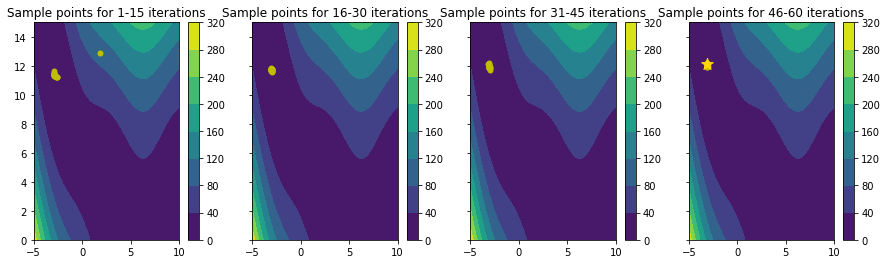

In [ ]:
import matplotlib.pyplot as plt

# noise_level=0.01
# create grid
first_param_grid = np.linspace(-5, 10, 150)
second_param_grid = np.linspace(0, 15, 150)
param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

# compute the objective function
fx = np.array([branin(x_i) for x_i in param_grid])
X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

# create figure
fig = plt.figure(figsize=(15,4))
ax1, ax2, ax3, ax4 = fig.subplots(1, 4, sharey=True)

# rendering
cp1 = ax1.contourf(X, Y, fx.reshape(X.shape))
ax1.scatter(ucb_xp1[5:20][:,0], ucb_xp1[5:20][:,1], c='y', marker = '.', s=100)
plt.colorbar(cp1, ax=ax1)
ax1.set_title("Sample points for 1-15 iterations")

cp2 = ax2.contourf(X, Y, fx.reshape(X.shape))
ax2.scatter(ucb_xp1[20:35][:,0], ucb_xp1[20:35][:,1], c='y', marker = '.', s=100)
plt.colorbar(cp2, ax=ax2)
ax2.set_title("Sample points for 16-30 iterations")

cp3 = ax3.contourf(X, Y, fx.reshape(X.shape))
ax3.scatter(ucb_xp1[35:50][:,0], ucb_xp1[35:50][:,1], c='y', marker = '.', s=100)
plt.colorbar(cp3, ax=ax3)
ax3.set_title("Sample points for 31-45 iterations")

cp4 = ax4.contourf(X, Y, fx.reshape(X.shape))
ax4.scatter(ucb_xp1[50:65][:,0], ucb_xp1[50:65][:,1], c='y', marker = '.', s=100)
ax4.scatter(ucb_xp1[np.argmax(ucb_yp1)][0], ucb_xp1[np.argmax(ucb_yp1)][1], marker='*', c='gold', s=150)
plt.colorbar(cp4, ax=ax4)
ax4.set_title("Sample points for 46-60 iterations")

plt.show()

In [ ]:
# ucb 0.01
sample_index = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 61, 62, 63, 64, 65])
plot_index = sample_index - 5
sample_ucb_x1 = []
sample_ucb_y1 = []
for i in sample_index:
    sample_ucb_x1.append(ucb_xp1[np.argmax(ucb_yp1[:i])])
    sample_ucb_y1.append(max(ucb_yp1[:i]))
    
plot_ucb_x1 = np.array(sample_ucb_x1)
plot_ucb_y1 = np.array(sample_ucb_y1)

In [ ]:
# ucb 0.05
sample_index = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 61, 62, 63, 64, 65])
plot_index = sample_index - 5
sample_ucb_x2 = []
sample_ucb_y2 = []
for i in sample_index:
    sample_ucb_x2.append(ucb_xp2[np.argmax(ucb_yp2[:i])])
    sample_ucb_y2.append(max(ucb_yp2[:i]))
    
plot_ucb_x2 = np.array(sample_ucb_x2)
plot_ucb_y2 = np.array(sample_ucb_y2)

In [ ]:
# ucb 0.1
sample_ucb_x3 = []
sample_ucb_y3 = []
for i in sample_index:
    sample_ucb_x3.append(ucb_xp3[np.argmax(ucb_yp3[:i])])
    sample_ucb_y3.append(max(ucb_yp3[:i]))
    
plot_ucb_x3 = np.array(sample_ucb_x3)
plot_ucb_y3 = np.array(sample_ucb_y3)